# Halite challenge - basics

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from Environment import halite_env as Env

In [2]:
from importlib import reload
reload(Env)

<module 'Environment.halite_env' from '/home/nicola/Nicola_unipd/QuartoAnno/TODO/Baiesi/RL/haliteRL/Environment/halite_env.py'>

## Setup of the environment - example

In [3]:
num_players = 1
map_size = 7 # 7 x 7 map

In [4]:
env = Env.HaliteEnv(num_players, map_size)

In [5]:
# halite in the map, min = 0, max = 1000
env.map[:,:,0]

array([[918,  62, 863, 876, 774, 336, 899],
       [839, 352, 524, 716, 813,  97,  99],
       [985, 285, 283,  23, 759, 787, 435],
       [317, 536, 454,   0, 724,  98, 139],
       [187, 839, 391, 158, 973,  73, 129],
       [902, 714, 233, 499, 134, 481, 455],
       [586, 679, 412, 654, 919, 572, 331]])

In [6]:
# ship position
env.map[:,:,1] 

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [7]:
# shows the halite carried from each ship in the position corresponding to the ship
# initially there is no ship, hence no halite carried either
env.map[:,:,2] 

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [8]:
# shipyard position
env.map[:,:,3] 

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [9]:
print("Initial halite: ", env.player_halite[0])

Initial halite:  [5000.]


In [10]:
# actions are represented as a matrix whose entries are -1 if no ship is in that position, 
#'a_i' if ship i is present in that position 
action_matrix = np.full((map_size,map_size), -1) # no ship, no action

# the environment already has in memory the last state, thus we don't need to resubmit it
# the only things that we submit are the action matrix and the shipyard action (1 or True to spawn a ship, 0 otherwise)
shipyard_action = 1 # initially always choose to create a ship
# returns the state, i.e. env.map
s, h, finish, _ = env.step(action_matrix, makeship = shipyard_action)
print(h[0])
print(finish)
# s_0 -> map_halite, s_1 -> ship_position, s_2 -> cargo_halite, s_3 -> shipyard_position (not used)
map_halite = s[:,:,0]
ship_pos_matrix = s[:,:,1]
shipy_pos_matrix = s[:,:,3]

[4000.]
False


## State complexity and state approximation

We have:
- $(map\_size)^2$ positions ($49$ in this case, up to $64^2 = 4096$ for the largest map);
- $1000$ values of halite for each position ($h\_lev$);
- $1000$ values of carried halite ($h\_lev$).

The state of the system is defined by the position of the ship + the halite in EACH cell + the halite carried by the ship. We can have almost all the possible combinations of the values that those variables can assume, thus we have the combinations of $1000$ values of halite for $50$ cells ($49$ of the map + the one carried by the ship) all multiplied by $49$ possible positions of the ship, for a total of $49\times 10^{147}$ possible states. If instead we consider the largest map of $64 \times 64$ we arrive at $4096\times 10^{12288}$ possible states.

The general formula can be written as: 
$$\# states = (map\_size)^2 \times (h\_lev)^{map\_size^2+1}$$

where we consider the map always centered on the shipyard, hence in this framework its position is fixed and not considered as a variable.
Of course this state representation is totally uncontrollable, because it scales exponentially in the number of cells of the map.

To tackle this issue we choose to drastically reduce the amount of information that is observed by the ship through two processes: partial observation and state abstraction.



### Partial observation: depth of field

The most expensive dependence in the formula about the number of states of the system is the exponent at which is elevated $h\_lev$. This is obtained considering all possible combinations of halite for all the cells of the map and the halite carried by the ship. A different approach is to consider only the halite inside the field of view of the agent and restrict the depth of field to the minimal possible quantity, i.e. nearest neighbors. In this way, independently from the $map\_size$ we get an exponent that in 2D is equal to 6 (4 for the neighbors, 1 for the state in which the ship stands and 1 for the halite it carries).

In other words, we get: 

$$\# states = (map\_size)^2 \times (h\_lev)^{6}$$

that yields $4.9 \times 10^{19}$ for the $7 \times 7$ map, that is still not manageable, but considerably smaller ( of order $ \approx 10^{120}$).

### State abstraction: halite quantization

Differently from the restriction on the observation space, that are somewhat straightforward, the state abstraction must involve some hypothesis about the environment that involve knowing the model of the environment. For example, if we were in the situation on not knowing how the halite is collected we probably would have done a different choice.
Since we know that the ship collects an amount of halite proportional to the halite in the cell (25% of it, to be more exact) and pays a fee of 10% of the halite contained in a cell to leave it, we are more interested in having encoded the notions of "low" and "high" halite levels, instead of sampling with precision the middle-high half of the halite scale. 
To be more specific, we choose to approximate the information about the halite using for $h_lev = 3$ halite levels and the following encoding:
- $h = 0$ if $halite \le 10$; 
- $h = 1$ if $10 < halite \le 100$; 
- $h = 2$ if $100 < halite \le 1000$.

The important part is that the halite is quantized in intervals that grow of a decade each, but we could also test adding a fourth level.
In this way the number of states of the system becomes:

$$\# states = (map\_size)^2 \times 3^{6}$$

yielding for a $7 \times 7$ map $35.721$ states, that is reachable with our resources. 

### State abstraction: meta-informations

The problem of these manipulations is that now the ship has access only to local informations and lacks of the knowledge about the position of the shipyard (but again, being the latter fixed, only the ship position is needed) and of that of distant halite deposits. In order to enhance the ability of the ship to find those deposits, we encode in a 4-states additional information the direction that the ship should take to go towards the nearest and richest deposit.
In this final formulation, the total number of states that needs to be experienced by the ship is:

$$\# states = (map\_size)^2 \times 3^{6} * 4$$

yielding for a $7 \times 7$ map the final result of $142.884$ states. Considering that each of these states requires 64 bits, i.e. 8 bytes, to be stored, the memory required to store the Q-value table is 1.143.072 bytes = 1.143 Mb.



## State encoding

We have seen how many states we have to handle for a $7 \times 7$ map, but each state is composed by different informations:

- $pos\_enc \in [0,48]$ (ship position encoded);
- $halite\_vector = (C, O, S, N, E, W)$ halite (where C stands for the halite carried by the ship and O for the cell occupied by the ship );
- $halite\_direction \in [1,4]$ (action to take to go towards the nearest and richest halite deposit).

The idea is to first encode the vector of halite using a one hot encoding, then to form a 3D tensor of $pos\_enc \times halvec\_enc \times haldir$ and encode it in a 1D array. This final array $s\_enc$ will form the rows of the Q(s,a) table and should assume values between 0 and 142.883.

In [11]:
# reinitialize the environment
env = Env.HaliteEnv(num_players, map_size)

### Initial turn

In [12]:
action_matrix = np.full((map_size,map_size), -1) # no ship, no action
shipyard_action = 1 # initially always choose to create a ship
# returns the state, i.e. env.map
s, h, finish, _ = env.step(action_matrix, makeship = shipyard_action)
# s_0 -> map_halite, s_1 -> ship_position, s_2 -> cargo_halite, s_3 -> shipyard_position (not used)
map_halite = s[:,:,0]

### Getting ship position (encoded and decoded)

In [13]:
# matrix to scalar encoding

def one_to_index(V,L):
    # matrix V with one entry = 1 and the others 0
    return np.arange(L**2).reshape((L, L))[V.astype(bool)]

# 2D encoding and decoding

def encode(v_dec, L):
    # v_two = [v1,v2]
    # returns the encoded version V[v1,v2] of V = np.arange(0,L)
    # L = length(all_possible_v)
    V = np.arange(0,L**2).reshape((L,L))
    v_enc = V[v_dec[0],v_dec[1]] 
    return v_enc

def decode(v_enc, L):
    V = np.arange(0,L**2).reshape((L,L))
    v_dec = np.array([np.where(v_enc == V)[0][0],np.where(v_enc == V)[1][0]])
    return v_dec

In [14]:
ship_pos_matrix = s[:,:,1]
shipy_pos_matrix = s[:,:,3]

#position_encoded of the ship
pos_enc = one_to_index(ship_pos_matrix, map_size)
print("Encoded position of the ship: ", pos_enc)
#position_decoded of the ship
pos_dec = decode(pos_enc, map_size)
print("Decoded position of the ship: ", pos_dec)

#position_encoded of the ship
shipy_enc = one_to_index(shipy_pos_matrix, map_size)
print("Encoded position of the shipyard: ", shipy_enc)
#position_decoded of the ship
shipy_dec = decode(shipy_enc, map_size)
print("Decoded position of the shipyard: ", shipy_dec)

Encoded position of the ship:  [24]
Decoded position of the ship:  [3 3]
Encoded position of the shipyard:  [24]
Decoded position of the shipyard:  [3 3]


### Getting halite vector (encoded and decoded)

In [15]:
def get_halite_vec_dec(state, q_number = 3, map_size = 7):
    
    def halite_quantization(h, q_number = 3):
        # h can either be a scalar or a matrix 
        tresholds = np.logspace(1,3,q_number) # [10, 100, 1000] = [10^1, 10^2, 10^3]
        h_shape = h.shape
        h_temp = h.flatten()
        mask = (h_temp[:,np.newaxis] < tresholds).astype(int)
        level = np.argmax(mask, axis = 1)
        return level.reshape(h_shape)

    pos_enc = one_to_index(state[:,:,1], map_size)
    pos_dec = decode(pos_enc, map_size) # decode position to access matrix by two indices
    
    ship_cargo = state[pos_dec[0],pos_dec[1],2]
    #print("Halite carried: ", ship_cargo)
    cargo_quant = halite_quantization(ship_cargo).reshape(1)[0] # quantize halite
    
    map_halite = state[:,:,0]
    halite_quant = halite_quantization(map_halite) # quantize halite
    
    halite_vector = []
    halite_vector.append(cargo_quant)
    halite_vector.append(halite_quant[pos_dec[0], pos_dec[1]])
    halite_vector.append(halite_quant[(pos_dec[0]+1)%map_size, pos_dec[1]])
    halite_vector.append(halite_quant[(pos_dec[0]-1)%map_size, pos_dec[1]])
    halite_vector.append(halite_quant[pos_dec[0], (pos_dec[1]+1)%map_size])
    halite_vector.append(halite_quant[pos_dec[0], (pos_dec[1]-1)%map_size])
    #print("Quantized halite vector: ", halite_vector)
    return np.array(halite_vector)

In [16]:
halvec_dec = get_halite_vec_dec(s)

Now we need to encode this vector of 6 elements whose values can be 0,1 or 2 in a scalar between 0 and $3^6 - 1$ (the encoding, of course, must be unique). The idea is similar to that of the 2D case, where we have a matrix whose element are numbered from 0 to the total number of elements - 1:
- to get the encoded state we read the element value whose indices are given by the ordered values stored in the array;
- to decode the encoded state and recover the decompressed array, we create a tensor (before it was a matrix) with the same shape of the tensor (matrix) that contains all the numbered states; this tensor has all the entries equal to the scalar value of the encoded state and we compare the two tensor and take the indices of the only element that is equal to the encoded state.


In [17]:
# valid for encoding and decoding an array of length L whose entries can all assume only 
# the same integer values from 0 to m
def encode_tensor(v_dec, L = 6, m = 3):
    T = np.arange(m**L).reshape(tuple([m for i in range(L)]))
    return T[tuple(v_dec)]

def decode_tensor(v_enc, L = 6, m = 3):
    T = np.arange(m**L).reshape(tuple([m for i in range(L)]))
    return np.array([np.where(v_enc == T)[i][0] for i in range(L)])

In [18]:
print("Original vector: ", halvec_dec)
v_enc = encode_tensor(halvec_dec)
print("Encoded vector: ", v_enc)
v_dec = decode_tensor(v_enc)
print("Decoded vector: ", v_dec)

Original vector:  [0 0 2 2 2 1]
Encoded vector:  79
Decoded vector:  [0 0 2 2 2 1]


### Getting halite direction 

In [19]:
def get_halite_direction(state, map_size = 7):
    
    def roll_and_cut(M, shift, axis, border = 1, center = (3,3)):
        M_temp = np.roll(M, shift = shift, axis = axis)
        M_cut = M_temp[center[0]-border:center[0]+border+1, center[1]-border:center[1]+border+1]
        return M_cut

    map_halite = state[:,:,0] # matrix with halite of each cell of the map
    
    pos_enc = one_to_index(state[:,:,1], map_size) # ship position
    pos_dec = decode(pos_enc, map_size) # decode position to access matrix by two indices
    
    shipy_enc = one_to_index(shipy_pos_matrix, map_size) # shipyard position
    shipy_dec = decode(shipy_enc, map_size) #position_decoded 
    
    shift = (shipy_dec[0]-pos_dec[0],shipy_dec[1]-pos_dec[1])
    centered_h = np.roll(map_halite, shift = shift, axis = (0,1)) #centers map_halite on the ship
    
    mean_cardinal_h = []
    # this could be generalized to wider areas, like 5x5, but 3x3 it's enough for a 7x7 map
    perm = [(a,sh) for a in [0,1] for sh in [-2,2]] # permutations of shifts and axis to get the 4 cardinal directions
    for a,sh in perm:
        mean_h = np.mean(roll_and_cut(centered_h, shift = sh, axis = a), axis = (0,1))
        mean_cardinal_h.append(mean_h)

    mean_cardinal_h = np.array(mean_cardinal_h)
    halite_direction = np.argmax(mean_cardinal_h) #+ 1 # take the direction of the 3x3 most rich zone
    
    return halite_direction

In [20]:
# Explanatory cell

# now suppose that the ship is in [2,2], whereas the shipyard is at the center of the map, i.e. [3,3]
example = np.roll(map_halite, shift = (1,1) , axis =  (0,1)) #in this way we simulate the ship to be in (2,2)
print("This is what we should get: \n", example)
pos_dec = [2,2]
shift = (shipy_dec[0]-pos_dec[0],shipy_dec[1]-pos_dec[1])
centered_h = np.roll(map_halite, shift = shift, axis = (0,1))
print("Result: \n",centered_h)

def roll_and_cut_v0(M, shift, axis, border = 1, center = (3,3)):
        M_temp = np.roll(M, shift = shift, axis = axis)
        M_cut = M_temp[center[0]-border:center[0]+border+1, center[1]-border:center[1]+border+1]
        return M_cut
    
# try to return just the 3x3 area around the ship
around_ship = roll_and_cut_v0(centered_h, shift = 0, axis = 0)
print("Neighborhood of the ship: \n", around_ship, '\n')
# we actually need to do this shifting by two in all cardinal directions w.r.t. the map centered around the ship
mean_cardinal_h = []
perm = [(a,sh) for a in [0,1] for sh in [-2,2]]
for a,sh in perm:
    print("Map shifted in direction: (%d,%d)\n"%(sh,a), roll_and_cut_v0(centered_h, shift = sh, axis = a))
    mean_h = np.mean(roll_and_cut_v0(centered_h, shift = sh, axis = a), axis = (0,1))
    print("Mean halite in direction: (%d,%d)"%(sh,a), mean_h, '\n')
    mean_cardinal_h.append(mean_h)

mean_cardinal_h = np.array(mean_cardinal_h)
halite_direction = np.argmax(mean_cardinal_h) #+ 1
print("Action suggested to reach the nearest and richest halite deposit: ", halite_direction)

This is what we should get: 
 [[200   4 395 150 369  38 492]
 [ 66 530 373 185 426 728 949]
 [232 956 312 523 373 950 800]
 [ 71 681 692 562 508 121 828]
 [539 233 526  67   0 929 996]
 [925 172 538 565 780  61 308]
 [903 966 789  80 511 512 740]]
Result: 
 [[200   4 395 150 369  38 492]
 [ 66 530 373 185 426 728 949]
 [232 956 312 523 373 950 800]
 [ 71 681 692 562 508 121 828]
 [539 233 526  67   0 929 996]
 [925 172 538 565 780  61 308]
 [903 966 789  80 511 512 740]]
Neighborhood of the ship: 
 [[312 523 373]
 [692 562 508]
 [526  67   0]] 

Map shifted in direction: (-2,0)
 [[526  67   0]
 [538 565 780]
 [789  80 511]]
Mean halite in direction: (-2,0) 428.44444444444446 

Map shifted in direction: (2,0)
 [[395 150 369]
 [373 185 426]
 [312 523 373]]
Mean halite in direction: (2,0) 345.1111111111111 

Map shifted in direction: (-2,1)
 [[373 950 800]
 [508 121 828]
 [  0 929 996]]
Mean halite in direction: (-2,1) 611.6666666666666 

Map shifted in direction: (2,1)
 [[232 956 312]
 [

### Encoding and decoding the total state

Starting from the encoded position, the encoded halite vector and the halite direction, we finally encode and decode this 3 contributions in a unique scalar that will take values between 0 and 142.883.

In [21]:
# 3D encoding and decoding for arbitrary lengths of the three axis

def encode3D(v_dec, L1, L2, L3):
    # v_dec = [v1,v2,v3]
    # returns the encoded version V[v1,v2,v3] of V = np.arange(0,L1*L2*L3)
    #print("v_dec: ", v_dec)
    #print("L1 = %d, L2 = %d, L3 = %d"%(L1,L2,L3))
    V = np.arange(0,L1*L2*L3).reshape((L1,L2,L3))
    v_enc = V[tuple(v_dec)] 
    return v_enc

def decode3D(v_enc, L1, L2, L3):
    # v_enc = V[v1,v2,v3] 
    # V = np.arange(0,L1*L2*L3)
    # returns the decoded version v_dec = [v1,v2,v3] of V[v1,v2,v3] 
    V = np.arange(0,L1*L2*L3).reshape((L1,L2,L3))
    v_dec = np.array([np.where(v_enc == V)[0][0],np.where(v_enc == V)[1][0], np.where(v_enc == V)[2][0]])
    return v_dec

In [22]:
print(pos_enc[0])
halvec_enc = encode_tensor(halvec_dec)
print(halvec_enc)
print(halite_direction)
s_dec = np.array([pos_enc[0], halvec_enc, halite_direction] )

24
79
2


In [23]:
h_lev = 3 # halite levels
n_cells = map_size**2 # number of cells in a square map
n_states = n_cells*h_lev**6*4
n_actions = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", n_states)

print("Original decoded state: ", s_dec)
s_enc = encode3D(s_dec, L1 = n_cells, L2 = h_lev**6, L3 = n_actions-1)
print("Encoded state: ", s_enc)
s_dec_2 = decode3D(s_enc, L1 = n_cells, L2 = h_lev**6, L3 = n_actions-1)
print("New decoded state: ", s_dec)

Total number of states to be experienced:  142884
Original decoded state:  [24 79  2]
Encoded state:  70302
New decoded state:  [24 79  2]


Now we put all together in order to have a single function that takes the multi-layer state output by the environment and returns the encoded state (that is the one we will use to access the Q-values).

In [24]:
def encode_state(state, map_size = 7, h_lev = h_lev, n_actions = n_actions, debug = False):
    
    pos_enc = one_to_index(state[:,:,1], map_size)[0] # ship position
    if debug:
        print("Ship position encoded in [0,%d]: "%(map_size**2-1), pos_enc)
    
    halvec_dec = get_halite_vec_dec(state, q_number = 3, map_size = map_size) 
    halvec_enc = encode_tensor(halvec_dec) # halite vector
    if debug:
        print("Halite vector encoded in [0,%d]: "%(h_lev**6 -1), halvec_enc)
    
    haldir = get_halite_direction(state, map_size = map_size) # halite direction
    if debug:
        print("Halite direction in [1,4]: ", haldir)
    
    s_dec = np.array([pos_enc, halvec_enc, haldir])
    if debug:
        print("Decoded state: ", s_dec)
    s_enc = encode3D(s_dec, L1 = map_size**2, L2 = h_lev**6, L3 = n_actions-1)
    if debug:
        print("State encoded in [0, %d]: "%(map_size**2*h_lev**6*(n_actions-1)), s_enc, '\n')
    
    return s_enc

In [25]:
encode_state(s, map_size = 7, h_lev = h_lev, n_actions = n_actions, debug = False)

70302

### Scalar and matricial action

The environment works for a generic number of ships. For this reason the action submitted must be a matrix of $map\_size \times map\_size$ filled with -1 except for the entry of the ship position, where it has to be entered the value of the action choosen.

In [26]:
def scalar_to_matrix_action(action, state, map_size = 7):
    # first get the decoded position of the ship
    ship_pos_matrix = state[:,:,1]
    pos_enc = one_to_index(ship_pos_matrix, map_size)
    pos_dec = decode(pos_enc, map_size)
    # then fill a matrix of -1
    mat_action = np.full((map_size,map_size), -1)
    # finally insert the action in the pos_dec entry
    mat_action[tuple(pos_dec)] = action
    return mat_action

In [27]:
#@@@@@@@@@@@@@@@@@@@
# RL agent functions
#@@@@@@@@@@@@@@@@@@@

def greedy_policy(s, q_values):
    return np.argmax(q_values[s])

def e_greedy_policy(s, q_values, eps = 0.01):
    # s is encoded in input, a is encoded in output
    u = np.random.rand()
    if u > eps:
        return np.argmax(q_values[s])
    else:
        return np.random.randint(0, len(q_values[s]))
    
def update_q(s, a, r, sp, ap, q_values, gamma = 1):
    q_values[s,a] = r + gamma*q_values[sp,ap]
    return q_values

In [62]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
num_players = 1
map_size = 7 # 7 x 7 map
tot_turns = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
h_lev = 3 # halite levels
n_cells = map_size**2 # number of cells in a square map
n_states = n_cells*h_lev**6*4
n_actions = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", n_states)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
n_batch = 100 # number of episodes in an epoch
max_epochs = 500 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
discount_factor = 1 - 1/tot_turns #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01

Total number of states to be experienced:  142884


In [60]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((n_states,n_actions)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(max_epochs)
halite_score = np.zeros(max_epochs)
epochs = 0

from tqdm import tnrange

for k in tnrange(max_epochs):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(n_batch) # bunch of 100 episodes
    halite_progress = np.zeros(n_batch) # bunch of 100 episodes
    eps = 0.5 # starting value of epsilon
    # generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
    epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/max_epochs), np.arange(0,max_epochs+1))))
    
    for i in range(n_batch):
        #@@@@@@@@@@@@@@@@@@@@@@@@
        # here starts an episode
        #@@@@@@@@@@@@@@@@@@@@@@@@
        env = Env.HaliteEnv(num_players, map_size, episode_lenght = tot_turns) # init environment
        steps = 0
        reward = 0
        
        # first mandatory step
        steps = steps + 1
        #print("\nStep number %d:"%steps)
        action_matrix = np.full((map_size,map_size), -1) # no ship, no action
        shipyard_action = 1 # initially always choose to create a ship
        # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
        state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
        #print("Cargo layer: \n", state[:,:,2])
        current_halite = players_halite[0][0]
        s_enc = encode_state(state, map_size = map_size, h_lev = h_lev, n_actions = n_actions, debug=False)
        
        while True:
            steps = steps + 1
            #print("\nStep number %d:"%steps)
            #print("Current halite: ", current_halite)
            a_enc = e_greedy_policy(s_enc, q_values, eps = epsilons[epochs])
            a_mat = scalar_to_matrix_action(a_enc, state, map_size = map_size)
            
            # submit the action and get the new state
            state, players_halite, finish, _ = env.step(a_mat, makeship = False) 
            #print("Cargo layer: \n", state[:,:,2])
            new_halite = players_halite[0][0]
            #print("New halite: ", new_halite)
            # compute the 1--ship reward as the halite increment of the player divided by the max halite 
            # plus a standard negative reward 
            r = (new_halite - current_halite)/1000 + STD_REWARD
            #print("Reward obtained: ", r)
            sp_enc = encode_state(state, map_size = map_size, h_lev = h_lev, n_actions = n_actions, debug=False)
            reward = reward + r # cumulative reward of the episode, obsolete
            
            a_temp_enc = greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)
            
            # update Q-values
            q_values = update_q(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, gamma = discount_factor)
            
            # update states and halite
            s_enc = sp_enc
            current_halite = new_halite
            
            if (finish == True) or (steps >= 400):
                #print("End episode.")
                reward_progress[i] = reward
                halite_progress[i] = current_halite - 4000
                break
        #break # play just 1 episode
                
    #break # play just 1 epoch

    print("Average reward per episode in epoch %d: %.3f"%(epochs, reward_progress.mean()))
    print("Average halite collected per episode in epoch %d: %.3f"%(epochs,halite_progress.mean()))
    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()

    if epochs >= max_epochs:
        print("Hey, I think you've had enough! Let's stop here.")
        break


Step number 2:
Current halite:  4000.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  4000.0
Reward obtained:  -0.01

Step number 3:
Current halite:  4000.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 137   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  4000.0
Reward obtained:  -0.01

Step number 4:
Current halite:  4000.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 239   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  4000.0
Reward obtained:  -0.01

Step number 5:
Current halite:  4000.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]


Step number 50:
Current halite:  4280.0
Cargo layer: 
 [[   0 1000    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
New halite:  4280.0
Reward obtained:  -0.01

Step number 51:
Current halite:  4280.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0]]
New halite:  4280.0
Reward obtained:  -0.01

Step number 52:
Current halite:  4280.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    

Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 881]]
New halite:  5280.0
Reward obtained:  -0.01

Step number 106:
Current halite:  5280.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 945]]
New halite:  5280.0
Reward obtained:  -0.01

Step number 107:
Current halite:  5280.0
Cargo layer: 
 [[  0   0   0   0   0   0 945]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  5280.0
Reward obtained:  -0.01

Step number 108:
Current halite:  5280.0
Cargo layer: 
 [[  0   0   0   0   0   0   


Step number 163:
Current halite:  6280.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 763   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  6280.0
Reward obtained:  -0.01

Step number 164:
Current halite:  6280.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 840   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  6280.0
Reward obtained:  -0.01

Step number 165:
Current halite:  6280.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 898   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  6280.0
Reward obtained:  -0.01

Step number 166:
Current halite:  6280.0
C

Step number 219:
Current halite:  8178.0
Cargo layer: 
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 220:
Current halite:  8178.0
Cargo layer: 
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 221:
Current halite:  8178.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0 217   0]
 [  0   0   0   0   0   0   0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 222:
Current halite:  8178.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0  

 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 992   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 262:
Current halite:  8178.0
Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0 992   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 263:
Current halite:  8178.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
New halite:  8178.0
Reward obtained:  -0.01

Step number 264:
Current halite:  8178.0
Cargo la


Step number 301:
Current halite:  10027.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  10027.0
Reward obtained:  -0.01

Step number 302:
Current halite:  10027.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  10027.0
Reward obtained:  -0.01

Step number 303:
Current halite:  10027.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  10027.0
Reward obtained:  -0.01

Step number 304:
Current halite:  10027.0
Cargo layer: 
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
New halite:  10027.0
Reward obtained:  -0.01

Step number 305:
Current halite:  10027.0
Cargo layer: 
 [

Cargo layer: 
 [[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0 328   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
New halite:  11027.0
Reward obtained:  -0.01

Step number 347:
Current halite:  11027.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  11355.0
Reward obtained:  0.318

Step number 348:
Current halite:  11355.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  11355.0
Reward obtained:  -0.01

Step number 349:
Current halite:  11355.0
Cargo layer: 
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
New halite:  11355.0
Reward obtained:  -0.01

Step number 350:
Current halite:  11355.0
Cargo laye


Step number 393:
Current halite:  11355.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
New halite:  11355.0
Reward obtained:  -0.01

Step number 394:
Current halite:  11355.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0]]
New halite:  11355.0
Reward obtained:  -0.01

Step number 395:
Current halite:  11355.0
Cargo layer: 
 [[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0 

In [31]:
#np.save("Q_values", q_values)

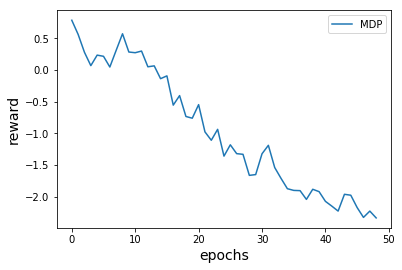

In [58]:
plt.plot(reward_score[:epochs-1], label = 'MDP')
plt.xlabel("epochs", fontsize = 14)
plt.ylabel("reward", fontsize = 14)
plt.legend()
plt.show()

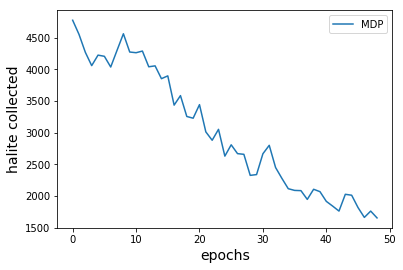

In [59]:
plt.plot(halite_score[:epochs-1], label = 'MDP')
plt.xlabel("epochs", fontsize = 14)
plt.ylabel("halite collected", fontsize = 14)
plt.legend()
plt.show()

In [63]:
experience = 100*400*max_epochs
tot_q = q_values.shape[0]* q_values.shape[1]
print("Maximal amount of states-actions experienced: ", experience)
print("Total amount of states-actions to be experienced: ", tot_q)

Maximal amount of states-actions experienced:  20000000
Total amount of states-actions to be experienced:  714420
